In [1]:
!pip install torchsummary

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 print(device)
 noisy_imgs_1 , noisy_imgs_2 = torch.load("/content/drive/MyDrive/deep_learning_epfl/train_data.pkl")

 noisy_imgs_1 = (noisy_imgs_1  / 255.0).float()
 noisy_imgs_2 = (noisy_imgs_2  / 255.0).float()

 noisy_imgs_1 = noisy_imgs_1.to(device)
 noisy_imgs_2 = noisy_imgs_1.to(device)


noisy_imgs_test, clean_images = torch.load("/content/drive/MyDrive/deep_learning_epfl/val_data.pkl")

noisy_imgs_test = (noisy_imgs_test / 250.0).float()
clean_images = (clean_images / 250.0).float()

noisy_imgs_test = noisy_imgs_test.to(device)
clean_images = clean_images.to(device)

cuda


# Normal Denoising Autoencoder

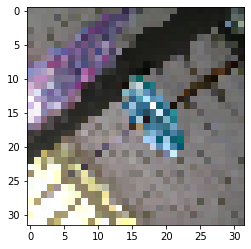

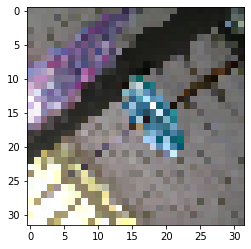

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 24, 24]          51,264
       BatchNorm2d-4           [-1, 64, 24, 24]             128
              ReLU-5           [-1, 64, 24, 24]               0
            Conv2d-6           [-1, 64, 11, 11]          65,600
              ReLU-7           [-1, 64, 11, 11]               0
            Conv2d-8             [-1, 64, 8, 8]          65,600
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 32, 5, 5]          32,800
  ConvTranspose2d-12             [-1, 64, 8, 8]          32,832
             ReLU-13             [-1, 64, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

In [15]:
plt.imshow(noisy_imgs_1[0].cpu().T)  # 3,32,32 to 32,32,3, .cpu() to bring them from the gpu
plt.show()  # display itnoisy_imgs_1[0])

plt.imshow(noisy_imgs_2[0].cpu().T) 
plt.show()  # display itnoisy_imgs_1[0])


class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
         nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1)),
         nn.ReLU(inplace = True),
         nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1)),
         nn.BatchNorm2d(64),
         nn.ReLU (inplace = True),
         nn.Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2)),
         nn.ReLU(inplace=True),
         nn.Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1)),
         nn.BatchNorm2d(64),
         nn.ReLU(inplace=True),
         nn.Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1)),
      )
        
        
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(1, 1)),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1)),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1,1)),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1)),
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
summary(model, (3, 32, 32)) 

In [17]:
# training

nb_epochs = 20
mini_batch_size = 100
start = time.time()

for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0) # prints how long training took, in minutes

Epoch 1 Train loss: 0.015680622
Test loss:  0.009323407
---
Epoch 2 Train loss: 0.01505577
Test loss:  0.009233073
---
Epoch 3 Train loss: 0.014492979
Test loss:  0.009186561
---
Epoch 4 Train loss: 0.013958066
Test loss:  0.009154943
---
Epoch 5 Train loss: 0.01346762
Test loss:  0.009169784
---
Epoch 6 Train loss: 0.013013954
Test loss:  0.009224301
---
Epoch 7 Train loss: 0.0125813885
Test loss:  0.009257191
---
Epoch 8 Train loss: 0.012174075
Test loss:  0.009285621
---
Epoch 9 Train loss: 0.011800829
Test loss:  0.009334315
---
Epoch 10 Train loss: 0.011448715
Test loss:  0.0093685305
---
Epoch 11 Train loss: 0.011130788
Test loss:  0.009477912
---
Epoch 12 Train loss: 0.010843089
Test loss:  0.009610633
---
Epoch 13 Train loss: 0.010578639
Test loss:  0.009690015
---
Epoch 14 Train loss: 0.010347388
Test loss:  0.009693443
---
Epoch 15 Train loss: 0.010131447
Test loss:  0.009738746
---
Epoch 16 Train loss: 0.009934114
Test loss:  0.009759405
---
Epoch 17 Train loss: 0.009758507


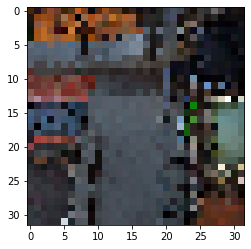

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


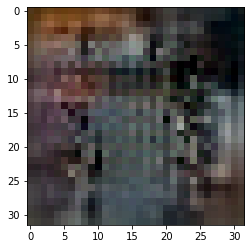

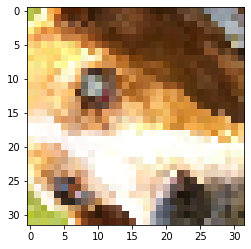

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


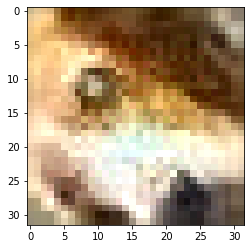

In [18]:
# Checking the results on the train set
imgs = noisy_imgs_1.narrow(0, 16, mini_batch_size)
imgs2 = noisy_imgs_2.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(2):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


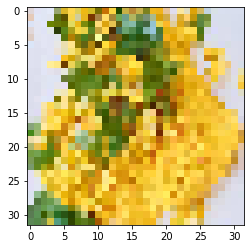

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


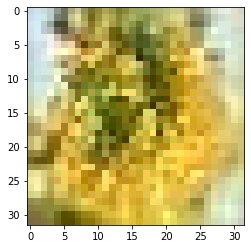

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


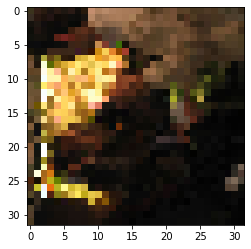

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


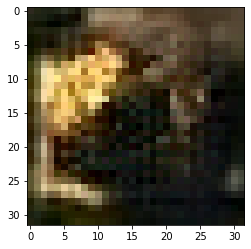

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


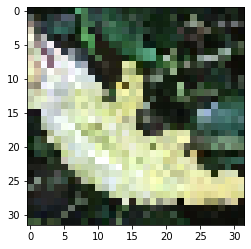

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


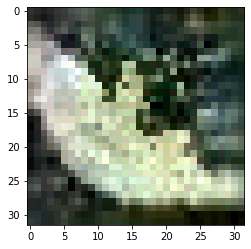

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


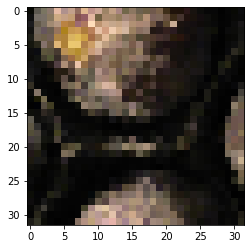

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


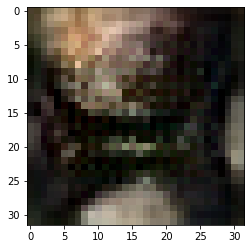

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


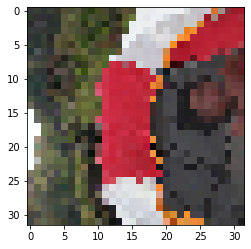

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


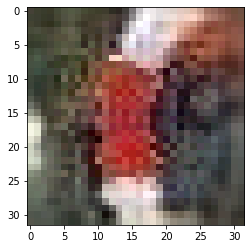

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


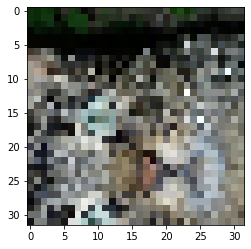

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


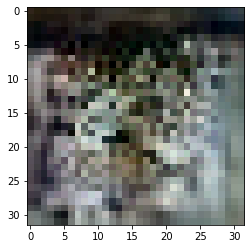

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


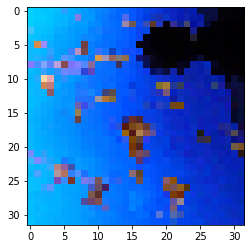

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


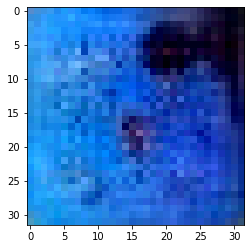

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


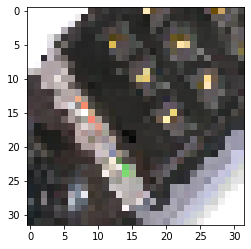

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


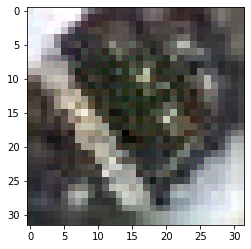

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


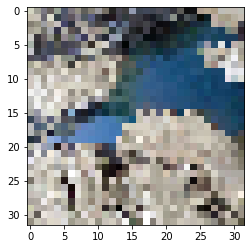

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


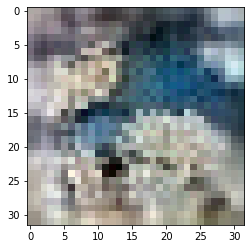

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


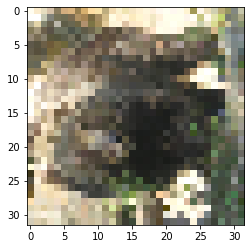

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


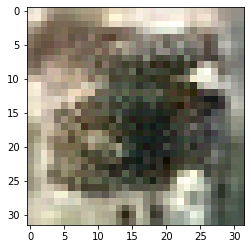

In [19]:
# Checking the results on the test set

imgs = noisy_imgs_test.narrow(0, 16, mini_batch_size)
imgs2 = clean_images.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(10):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()

In [20]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(20.0655, device='cuda:0', grad_fn=<MulBackward0>)


# UNet

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


model = UNet(3,3,4, padding = True).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         Dropout2d-5           [-1, 64, 32, 32]               0
     UNetConvBlock-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        Dropout2d-11          [-1, 128, 16, 16]               0
    UNetConvBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [ ]:
nb_epochs = 10
mini_batch_size = 100
start = time.time()

for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0)

Epoch 1 Train loss: 0.0023565101
Test loss:  0.013505325
---
Epoch 2 Train loss: 0.0021647632
Test loss:  0.013075925
---
Epoch 3 Train loss: 0.0020434214
Test loss:  0.012472562
---
Epoch 4 Train loss: 0.0019359661
Test loss:  0.012349807
---
Epoch 5 Train loss: 0.0018264179
Test loss:  0.01258285
---
Epoch 6 Train loss: 0.0017261143
Test loss:  0.013814097
---
Epoch 7 Train loss: 0.001713425
Test loss:  0.012529489
---
Epoch 8 Train loss: 0.0016299515
Test loss:  0.011614695
---
Epoch 9 Train loss: 0.0016205927
Test loss:  0.012880033
---
Epoch 10 Train loss: 0.0015802598
Test loss:  0.012553449
---
7.204729759693146


In [ ]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(19.0391, device='cuda:0', grad_fn=<MulBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


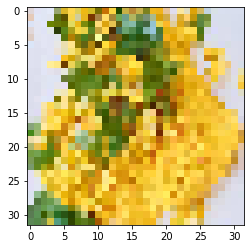

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


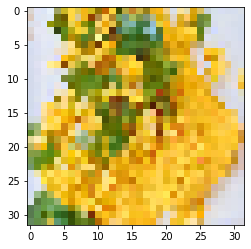

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


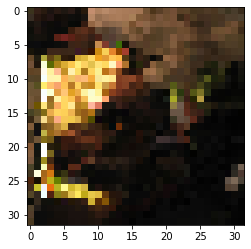

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


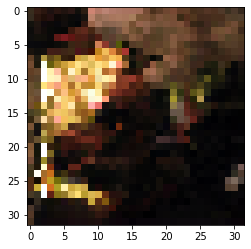

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


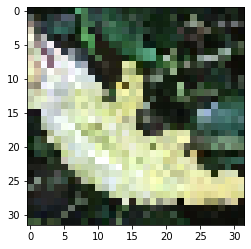

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


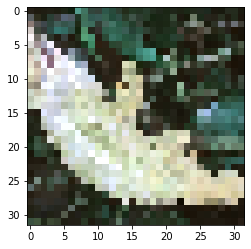

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


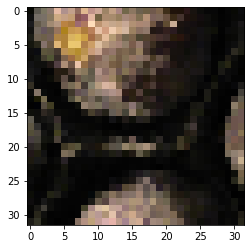

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


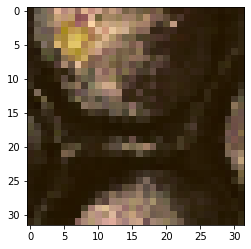

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


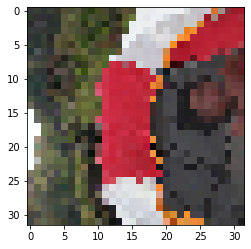

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


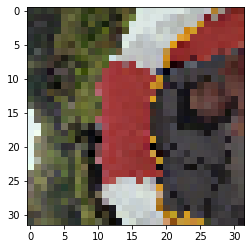

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


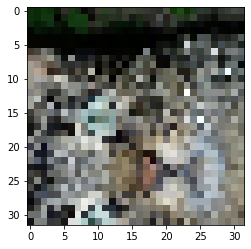

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


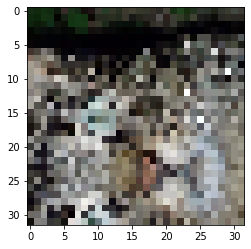

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


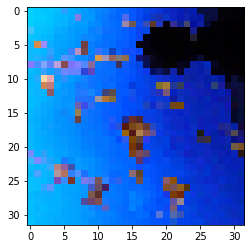

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


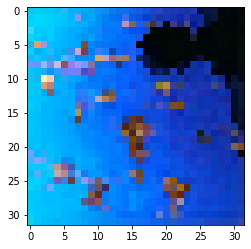

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


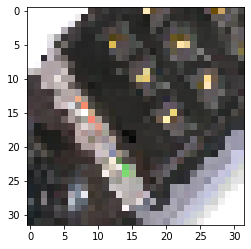

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


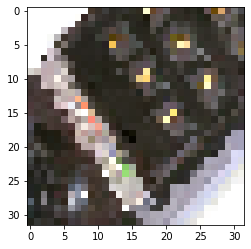

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


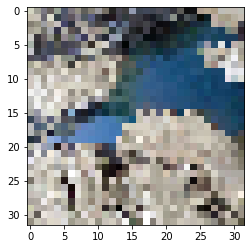

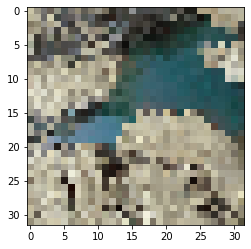

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


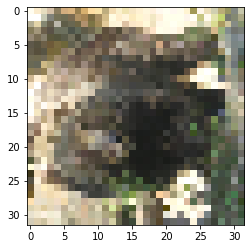

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


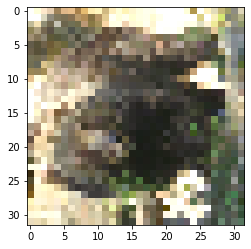

In [ ]:
imgs = noisy_imgs_test.narrow(0, 16, mini_batch_size)
imgs2 = clean_images.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(10):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()

# ResNet

In [10]:
# https://github.com/rishikksh20/ResUnet

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class ResUnet(nn.Module):
    def __init__(self, channel, filters=[8, 16, 32, 64]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 3, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output


model = ResUnet(3).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
summary(model, (3, 32, 32))

img = torch.ones(1, 3, 32, 32).to(device)
resunet = ResUnet(3).to(device)
print(resunet(img).size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
            Conv2d-4            [-1, 8, 32, 32]             584
            Conv2d-5            [-1, 8, 32, 32]             224
       BatchNorm2d-6            [-1, 8, 32, 32]              16
              ReLU-7            [-1, 8, 32, 32]               0
            Conv2d-8           [-1, 16, 16, 16]           1,168
       BatchNorm2d-9           [-1, 16, 16, 16]              32
             ReLU-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,320
           Conv2d-12           [-1, 16, 16, 16]           1,168
      BatchNorm2d-13           [-1, 16, 16, 16]              32
     ResidualConv-14           [-1, 16,

In [12]:
nb_epochs = 10
mini_batch_size = 100
start = time.time()


for e in range(nb_epochs):
    train_loss = []
    for b in range(0, noisy_imgs_1.size(0), mini_batch_size):
        output = model(noisy_imgs_1.narrow(0, b, mini_batch_size))
        loss = criterion(output, noisy_imgs_2.narrow(0, b, mini_batch_size))
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch", e + 1, "Train loss:", np.mean(train_loss))

    # Test the model
    with torch.no_grad():
      test_results = model(noisy_imgs_test)
      print("Test loss: ", criterion(test_results, clean_images).cpu().numpy())
      print("---")


end = time.time()
print((end - start) / 60.0)

Epoch 1 Train loss: 0.0008226458786521107
Test loss:  0.010683972
---
Epoch 2 Train loss: 0.0006737644523964264
Test loss:  0.010715373
---
Epoch 3 Train loss: 0.0005810482876840979
Test loss:  0.0107453335
---
Epoch 4 Train loss: 0.0005146037280501332
Test loss:  0.010785483
---
Epoch 5 Train loss: 0.0004628060781105887
Test loss:  0.0109274965
---
Epoch 6 Train loss: 0.0004225906659848988
Test loss:  0.0109688975
---
Epoch 7 Train loss: 0.0003888548631512094
Test loss:  0.011056849
---
Epoch 8 Train loss: 0.000357890650164336
Test loss:  0.011006359
---
Epoch 9 Train loss: 0.00033587523168534974
Test loss:  0.011124111
---
Epoch 10 Train loss: 0.0003113705732685048
Test loss:  0.011062879
---
2.008235418796539


In [13]:
def psnr( denoised , ground_truth ) :
  # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
  mse = torch.mean(( denoised - ground_truth ) ** 2)
  return -10 * torch.log10( mse + 10**-8)


results = model(noisy_imgs_test)

print(psnr(results, clean_images))

tensor(19.5613, device='cuda:0', grad_fn=<MulBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


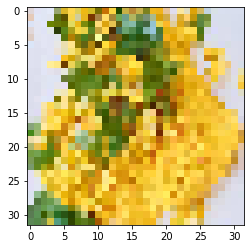

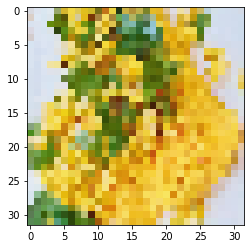

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


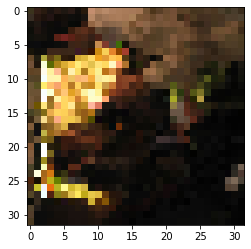

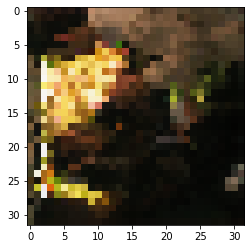

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


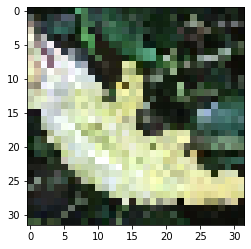

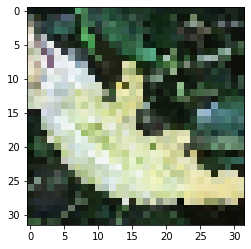

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


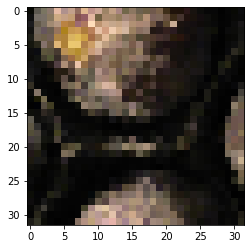

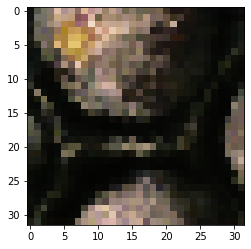

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


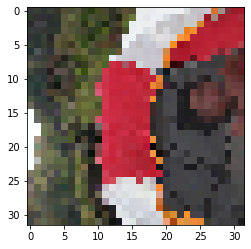

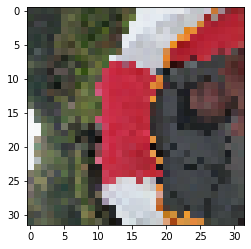

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


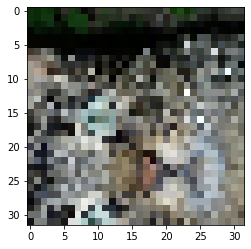

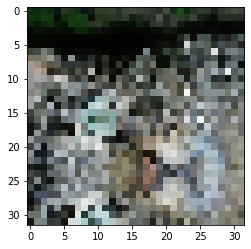

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


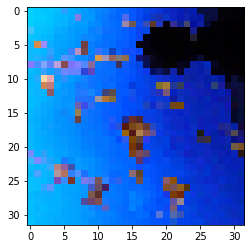

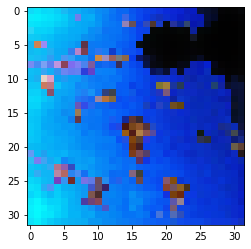

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


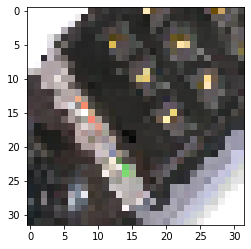

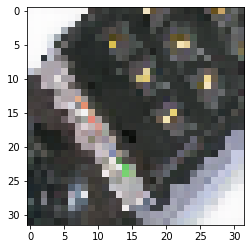

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


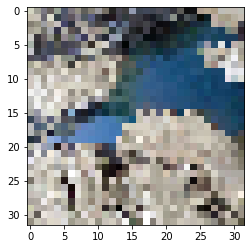

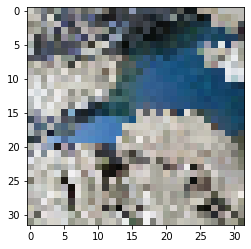

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


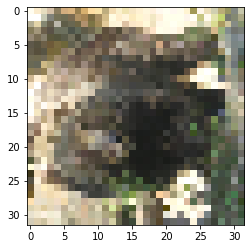

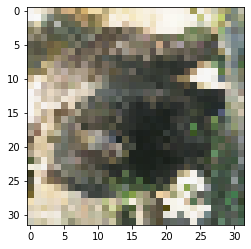

In [14]:
imgs = noisy_imgs_test.narrow(0, 16, mini_batch_size)
imgs2 = clean_images.narrow(0, 16, mini_batch_size)

results = model(imgs).cpu().detach().numpy()


for i in range(10):
  plt.imshow(imgs[i].cpu().T)
  plt.show()

  plt.imshow(results[i].T)
  plt.show()